# Time Series Analysis

## Miembros
- Andrés Montoya 21552
- Fernanda Esquivel 21542
- Francisco Castillo 21562
- Fabián Juárez 21440
- Diego Lemus 21469

## Link al repositorio
El repositorio puede ser visualizado [acá](https://github.com/FerEsq/DL-TimeSeries-Analysis)

# Task 1

## Limpieza de datos

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [2]:
#Cargar los datos
train_data = pd.read_csv('data/train.csv')

#Convertir la columna 'date' a formato datetime
train_data['date'] = pd.to_datetime(train_data['date'])

#Extraer características de la fecha
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day_of_week'] = train_data['date'].dt.dayofweek

#Escalar los datos de ventas ('sales') usando StandardScaler
scaler = StandardScaler()
train_data['sales_scaled'] = scaler.fit_transform(train_data[['sales']])

#Verificar los primeros datos transformados
train_data.head()


,date,store,item,sales,year,month,day_of_week,sales_scaled
0,2013-01-01,1,1,13,2013,1,1,-1.362804
1,2013-01-02,1,1,11,2013,1,2,-1.432246
2,2013-01-03,1,1,14,2013,1,3,-1.328083
3,2013-01-04,1,1,13,2013,1,4,-1.362804
4,2013-01-05,1,1,10,2013,1,5,-1.466966


## Preprocesamiento de datos

In [3]:
#Dividir el conjunto de datos en entrenamiento, validación y prueba
train_size = 0.70  # 70% para entrenamiento
validation_size = 0.15  # 15% para validación
test_size = 0.15  # 15% para prueba

total_rows = len(train_data)
train_index = int(total_rows * train_size)
validation_index = int(total_rows * (train_size + validation_size))

train_set = train_data.iloc[:train_index]
validation_set = train_data.iloc[train_index:validation_index]
test_set = train_data.iloc[validation_index:]

In [4]:
#Función para generar secuencias de datos históricos y pronósticos
def create_sequences(data, window_size, forecast_horizon):
    sequences = []
    targets = []
    
    for i in range(len(data) - window_size - forecast_horizon + 1):
        window = data.iloc[i:i + window_size]['sales'].values
        target = data.iloc[i + window_size:i + window_size + forecast_horizon]['sales'].sum()
        sequences.append(window)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

In [5]:
#Parámetros de secuencias
window_size = 90  #Ventana histórica de 90 días
forecast_horizon = 90  #Pronóstico de 3 meses (90 días)

#Muestra para entrenar y generar secuencias
train_sample = train_set.sample(n=50000, random_state=42)

In [6]:
#Generar secuencias para el conjunto de entrenamiento
train_sequences, train_targets = create_sequences(train_sample, window_size, forecast_horizon)

In [7]:
#Imprimir las dimensiones de las secuencias generadas
print("Dimensiones de las secuencias de entrenamiento:", train_sequences.shape)
print("Dimensiones de los objetivos de entrenamiento:", train_targets.shape)

Dimensiones de las secuencias de entrenamiento: (49821, 90)
Dimensiones de los objetivos de entrenamiento: (49821,)


In [9]:
# Redimensionar las secuencias para que tengan la forma [muestras, pasos de tiempo, características]
train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))

### LSTM

In [10]:
# Modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 90, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#train
history = model.fit(train_sequences, train_targets, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 125s 94ms/step - loss: 23001326.0000 - val_loss: 15610872.0000
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 110s 88ms/step - loss: 12516314.0000 - val_loss: 4142700.2500
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 114s 92ms/step - loss: 3313401.5000 - val_loss: 405793.3438
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 111s 89ms/step - loss: 1351880.3750 - val_loss: 147767.9219
Epoch 5/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 103s 82ms/step - loss: 1291496.5000 - val_loss: 137387.0938
Epoch 6/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - loss: 1312866.6250 - val_loss: 145197.0156
Epoch 7/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - loss: 1287947.8750 - val_loss: 130688.0000
Epoch 8/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 102s 82ms/step - loss: 1286458.8750 - val_loss: 138523.1875
Epoch 9/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 101s 81ms/step - loss: 1298678.0000 - val_loss: 134766.7344
Epoch 10/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 101s 81ms/step - loss: 1279431.750

In [12]:
#save model
model.save('models/model_LSTM.h5')

In [15]:
#load model
model = tf.keras.models.load_model('models/model_LSTM.h5', custom_objects={'mse': MeanSquaredError()})

In [16]:
validation_sequences, validation_targets = create_sequences(validation_set, window_size, forecast_horizon)
validation_sequences = validation_sequences.reshape((validation_sequences.shape[0], validation_sequences.shape[1], 1))

val_loss = model.evaluate(validation_sequences, validation_targets)
print(f'Pérdida en el conjunto de validación: {val_loss}')

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 105s 24ms/step - loss: 6905494.5000
Pérdida en el conjunto de validación: 5464758.5


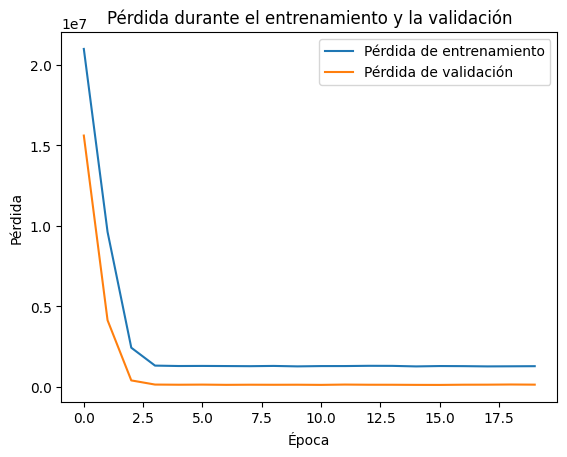

In [19]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [20]:
test_sequences, test_targets = create_sequences(test_set, window_size, forecast_horizon)
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

predictions = model.predict(test_sequences)

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 110s 26ms/step


In [23]:
mae = mean_absolute_error(test_targets, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

mse = mean_squared_error(test_targets, predictions)
rmse = np.sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

r2 = r2_score(test_targets, predictions)
print(f"R² (Coeficiente de determinación): {r2}")

Mean Absolute Error (MAE): 1841.3071598122958
Mean Squared Error (MSE): 4838448.091209935
Root Mean Squared Error (RMSE): 2199.647265179109
R² (Coeficiente de determinación): -0.019646763801574707


### GRU

In [24]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

# Compilar el modelo
model_gru.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model_gru.summary()

c:\Users\monto\OneDrive\Documents\UVG\8. Octavo semestre\Dl\DL-TimeSeries-Analysis\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 90, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,817 (89.13 KB)

 Trainable params: 22,817 (89.13 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history = model_gru.fit(train_sequences, train_targets, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 130s 100ms/step - loss: 23082638.0000 - val_loss: 16407990.0000
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 153s 123ms/step - loss: 13511784.0000 - val_loss: 5271527.5000
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 145s 117ms/step - loss: 4211038.0000 - val_loss: 684327.7500
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 143s 114ms/step - loss: 1587042.1250 - val_loss: 177034.4219
Epoch 5/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 143s 115ms/step - loss: 1466516.6250 - val_loss: 159704.0469
Epoch 6/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 146s 117ms/step - loss: 1471392.7500 - val_loss: 158733.3281
Epoch 7/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 129s 103ms/step - loss: 1455134.1250 - val_loss: 156360.0469
Epoch 8/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 134s 108ms/step - loss: 1464142.0000 - val_loss: 158338.5312
Epoch 9/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 129s 104ms/step - loss: 1443051.6250 - val_loss: 145968.2188
Epoch 10/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 135s 109ms/step - loss: 1

In [26]:
#save model
model_gru.save('models/model_GRU.h5')

In [27]:
#load model
model_gru = tf.keras.models.load_model('models/model_GRU.h5', custom_objects={'mse': MeanSquaredError()})

In [28]:
validation_sequences, validation_targets = create_sequences(validation_set, window_size, forecast_horizon)
validation_sequences = validation_sequences.reshape((validation_sequences.shape[0], validation_sequences.shape[1], 1))

val_loss = model_gru.evaluate(validation_sequences, validation_targets)
print(f'Pérdida en el conjunto de validación: {val_loss}')

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 114s 26ms/step - loss: 6955387.0000
Pérdida en el conjunto de validación: 5419421.5


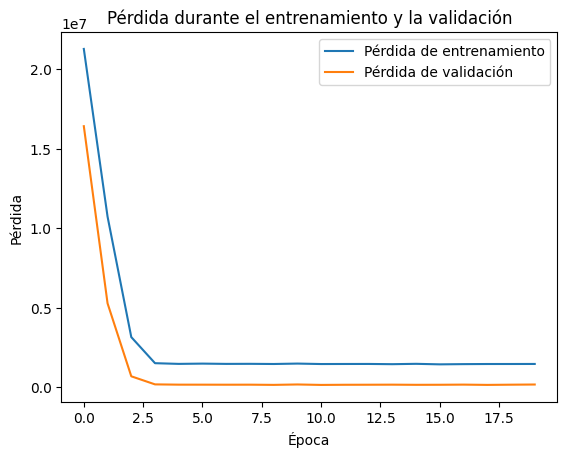

In [29]:
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [30]:
test_sequences, test_targets = create_sequences(test_set, window_size, forecast_horizon)
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

predictions = model_gru.predict(test_sequences)

4275/4275 ━━━━━━━━━━━━━━━━━━━━ 121s 28ms/step


In [31]:
mae = mean_absolute_error(test_targets, predictions)
print(f"MAE: {mae}")

mse = mean_squared_error(test_targets, predictions)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

r2 = r2_score(test_targets, predictions)
print(f"R²: {r2}")

MAE: 1831.97065141262
MSE: 4812324.554903216
RMSE: 2193.701108834842
R²: -0.014141440391540527


# Task 2

#### 1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales?
* El problema del gradiente de fuga ocurre cuando los gradientes que se propagan a través de las capas de una red neuronal recurrente, como una LSTM, se hacen extremadamente pequeños durante la retropropagación. Esto sucede principalmente en secuencias largas, donde los gradientes se diluyen antes de llegar a las capas iniciales, afectando la capacidad del modelo para aprender dependencias a largo plazo. 
* En el contexto de pronóstico de series temporales, este problema reduce la efectividad de las LSTM al dificultar la captación de patrones o relaciones en series de datos que dependen de eventos distantes en el tiempo. Aunque las LSTM están diseñadas para mitigar este problema mediante su arquitectura de puertas, no lo eliminan completamente, y su desempeño puede verse afectado si las secuencias son demasiado largas o si los datos son ruidosos


#### 2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?
* La estacionalidad en series temporales se refiere a patrones recurrentes que se repiten en intervalos regulares. Para abordar este aspecto al usar LSTM, es común aplicar transformaciones previas a los datos, como la diferenciación estacional, que ayuda a eliminar estos patrones recurrentes antes de entrenar el modelo.
* La diferenciación es una técnica que implica restar valores consecutivos de la serie, ayudando a estabilizar la serie y remover tendencias o estacionalidades. Al hacerlo, el modelo LSTM puede concentrarse en predecir patrones más consistentes, sin ser desviado por ciclos repetitivos. Además de la diferenciación, otras técnicas incluyen el uso de características adicionales (lags) o la incorporación de la información estacional directamente como una entrada al modelo. De esta manera, las LSTM son capaces de enfocarse tanto en las fluctuaciones a corto plazo como en las tendencias subyacentes.


#### 3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?
* El "tamaño de ventana" se refiere a la cantidad de datos históricos que se utilizan como entrada para el modelo LSTM para predecir el siguiente valor en la serie temporal. Es una ventana deslizante que define el horizonte temporal que el modelo usa para hacer su predicción.
* Si el tamaño de ventana es demasiado pequeño, el modelo puede no tener suficiente información para capturar patrones a largo plazo, lo que afecta su capacidad para hacer predicciones precisas en series con tendencias prolongadas.
* Por otro lado, un tamaño de ventana demasiado grande puede incluir demasiados datos irrelevantes, lo que lleva a un modelo más complejo que podría sobreajustarse a los patrones de ruido en lugar de generalizar. La elección del tamaño de ventana es crucial porque define el equilibrio entre la capacidad del modelo para detectar patrones a corto y largo plazo, y afecta directamente su desempeño en tareas de pronóstico.


### Referencias
1. Buckley, B. (2023). ¿Cuál es el problema del gradiente de fuga? - Academia EITCA. EITCA Academy. https://es.eitca.org/artificial-intelligence/eitc-ai-gcml-google-cloud-machine-learning/first-steps-in-machine-learning/deep-neural-networks-and-estimators/what-is-the-vanishing-gradient-problem/
2. Rojas-Jimenez, K. (s. f.). Capítulo 8 Análisis de Series de Tiempo | Ciencia de Datos para Ciencias Naturales. https://bookdown.org/keilor_rojas/CienciaDatos/an%C3%A1lisis-de-series-de-tiempo.html
3. Andrés, D., & Andrés, D. (2023). Métodos de pronóstico de Series Temporales - ML Pills. ML Pills - Machine Learning Pills. https://mlpills.dev/series-temporales/pronostico-de-series-temporales/